In [1]:
import mujoco as mj
from mujoco.glfw import glfw
import numpy as np
import math
from callbacks import *
from scipy.spatial.transform import Rotation as R

/opt/homebrew/Caskroom/miniforge/base/envs/cs590/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
xml_path = 'models/mushr.xml' #xml file (assumes this is in the same folder as this file)
view = "third"
assert view in ["first","third"]
simend = 600

# MuJoCo data structures
model = mj.MjModel.from_xml_path(xml_path)  # MuJoCo model
data  = mj.MjData(model)                    # MuJoCo data
cam   = mj.MjvCamera()                        # Abstract camera
opt   = mj.MjvOption()                        # visualization options

In [3]:
# Init GLFW, create window, make OpenGL context current, request v-sync
glfw.init()
window = glfw.create_window(800, 600, "Demo", None, None)
glfw.make_context_current(window)
glfw.swap_interval(1)

# initialize visualization data structures
mj.mjv_defaultCamera(cam)
mj.mjv_defaultOption(opt)
scene = mj.MjvScene(model, maxgeom=10000)
context = mj.MjrContext(model, mj.mjtFontScale.mjFONTSCALE_150.value)

cb = Callbacks(model,data,cam,scene)

# install GLFW mouse and keyboard callbacks
glfw.set_key_callback(window, cb.keyboard)
glfw.set_cursor_pos_callback(window, cb.mouse_move)
glfw.set_mouse_button_callback(window, cb.mouse_button)
glfw.set_scroll_callback(window, cb.scroll)

# Example on how to set camera configuration
cam.azimuth = -90 ; cam.elevation = -45 ; cam.distance =  13
cam.lookat =np.array([ 0.0 , 0.0 , 0.0 ])

In [4]:
class Controller:
    def __init__(self,model,data):
        # Initialize the controller here.
        pass
    
    def controller(self,model,data):
        data.ctrl[0] = 0.25
        data.ctrl[1] = 2.0

c = Controller(model,data)
mj.set_mjcb_control(c.controller)

In [5]:
trajectory = []
trajectory2 = []

#Naive function to check collision
def in_collision(data):
    
    # Get the COM of the car to implement center-distance based collision detection
    totalmass = 0
    center_x = 0
    center_y = 0
    center_z = 0

    # Skip 0 because it's the World Body and final because it's the human site
    for i in range(1, len(data.xpos)-1):
        totalmass += model.body_mass[i]
        center_x += data.xpos[i][0]*model.body_mass[i]
        center_y += data.xpos[i][1]*model.body_mass[i]
        center_z += data.xpos[i][2]*model.body_mass[i]

    center_x /= totalmass
    center_y /= totalmass
    center_z /= totalmass
    
    #Let Point 1 and 2 be the center of the car body and human site respectively
    point1 = [center_x, center_y, center_z]
    point2 = data.site_xpos[1]
    
    #Return the euclidean distance between the two centers
    #(only x and y, no z difference needed since human is a cylinder)
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

#Flag to be switched on collision
break_flag = 1

#Threshold for distance between centers to break simulation
threshold = 0.45

while break_flag and not glfw.window_should_close(window):
    time_prev = data.time

    while (data.time - time_prev < 1.0/60.0):
        mj.mj_step(model,data)
        
        status = in_collision(data)
        
        if status < threshold:
            break_flag = 0
        
        trajectory.append(np.copy(data.qpos))
        trajectory2.append(np.copy(data.site_xpos[1]))
        
        if view == "first":
            cam.lookat[0] = data.site_xpos[1][0]
            cam.lookat[1] = data.site_xpos[1][1]
            cam.lookat[2] = data.site_xpos[1][2] + 0.5
            cam.elevation = 0.0
            cam.distance = 1.0
    
    if data.time >= simend:
        break

    # ==================================================================================
    # The below code updates the visualization -- do not modify it!
    # ==================================================================================
    # get framebuffer viewport
    viewport_width, viewport_height = glfw.get_framebuffer_size(window)
    viewport = mj.MjrRect(0, 0, viewport_width, viewport_height)

    # Update scene and render
    mj.mjv_updateScene(model, data, opt, None, cam, mj.mjtCatBit.mjCAT_ALL.value, scene)
    mj.mjr_render(viewport, scene, context)

    # swap OpenGL buffers (blocking call due to v-sync)
    glfw.swap_buffers(window)

    # process pending GUI events, call GLFW callbacks
    glfw.poll_events()
    

glfw.terminate()

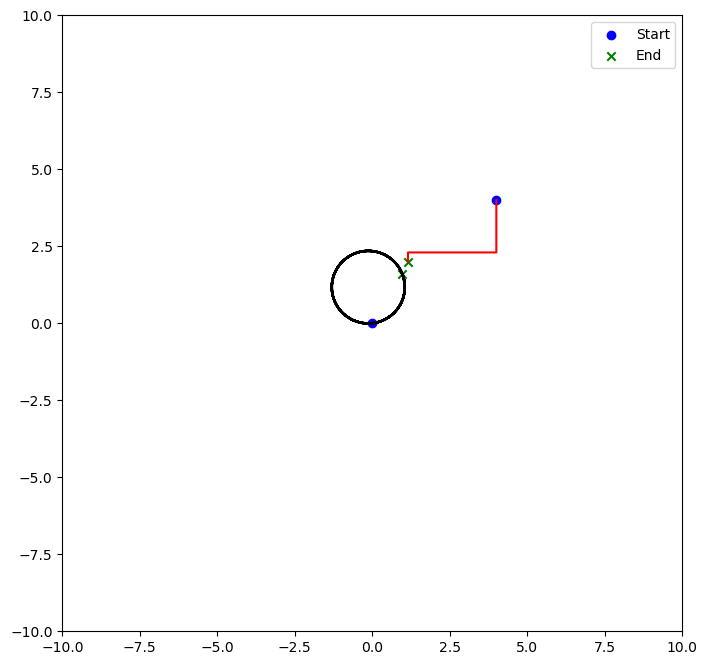

In [6]:
import matplotlib.pyplot as plt
# You need the below line only if you're using this inside a Jupyter notebook.
%matplotlib inline

trajectory = np.array(trajectory)
trajectory2 = np.array(trajectory2)

plt.figure(figsize=(8,8))
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.plot(trajectory[:,0],trajectory[:,1],color='black')
plt.plot(trajectory2[:,0],trajectory2[:,1],color='red')
plt.scatter(trajectory[0,0],trajectory[0,1],marker='o', c='blue',label='Start')
plt.scatter(trajectory[-1,0],trajectory[-1,1],marker='x',c='green', label='End')
plt.scatter(trajectory2[0,0],trajectory2[0,1],marker='o', c='blue',)
plt.scatter(trajectory2[-1,0],trajectory2[-1,1],marker='x', c='green',)
plt.legend(loc='best')
plt.show()